# Timeseries Graph Script

##### environ. prep

In [1]:
%cd /mnt/Data/Jupyter/Neo4j

/mnt/Data/Jupyter/Neo4j


In [2]:
import warnings
warnings.filterwarnings("ignore")
%load_ext rpy2.ipython

In [3]:
import os
import numpy as np
import pandas as pd
import pickle
from datetime import date, datetime, timedelta

In [4]:
import quandl
import auth
quandl.ApiConfig.api_key = auth.quandl_api_key
ONLINEMODE = False

In [5]:
%%R
require('tidyverse')
require('ggplot2')
require("reshape2")
require('cowplot')
theme_set(theme_grey())

In [6]:
from py2neo import Graph, Transaction
graph = Graph(bolt=True, password=auth.password)

In [7]:
def retrieveQuandl(dataId, forceNew=False):
    """
    Retrieve specified data from Quandl.  
    By default will first look in pwd for picked data.
    forcePull=True forces the function to pull fresh data from Quandl.
    """
    pklPath = "{}.pkl".format(dataId).replace("/","-")
    if forceNew == False:
        try:
            f = open(pklPath, "rb")
            df = pickle.load(f)   
            print("Loaded {} from pwd".format(dataId))
        except (OSError, IOError) as e:
            print("Downloading {} from Quandl".format(dataId))
            df = quandl.get(dataId, returns="pandas")
            df.to_pickle(pklPath)
            print("Saved {} to pwd".format(pklPath))
        return df
    else:
        print("Downloading {} from Quandl".format(dataId))
        df = quandl.get(dataId, returns="pandas") 
        df.to_pickle(pklPath)
        print("Saved {} to pwd".format(pklPath))
    return df

# btcKraken = retrieveQuandl("BCHARTS/KRAKENUSD", forceNew=True)

def btcExchanges(altExchanges=["KRAKEN", "COINBASE", "BITSTAMP", "ITBIT"], forceNew=False):
    
    exchangeData = {}
    
    [exchangeData.update({i[0]:retrieveQuandl(i[1], forceNew)}) for i in
    ((exchange, "BCHARTS/{}USD".format(exchange)) for exchange in altExchanges)]
    
    return exchangeData
    
# btc = btcExchanges(["KRAKEN", "COINBASE", "BITSTAMP", "ITBIT"], forceNew=False)

def getBTC(altExchanges=["KRAKEN", "COINBASE", "BITSTAMP", "ITBIT"], forceNew=False):
    exchangeData = btcExchanges(altExchanges, forceNew)

    btc = pd.DataFrame()

    btc["BTC_weighted_price"] = pd.DataFrame(
        exchangeData["{}".format(exchange)]["Weighted Price"] 
        for exchange in altExchanges).replace(0, np.nan).mean()

    btc["BTC_volume"] = pd.DataFrame(
        exchangeData["{}".format(exchange)]["Volume (BTC)"] 
        for exchange in altExchanges).replace(0, np.nan).mean()

    btc["BTC_open"] = pd.DataFrame(
        exchangeData["{}".format(exchange)]["Open"] 
        for exchange in altExchanges).replace(0, np.nan).mean()
    
    btc["BTC_high"] = pd.DataFrame(
        exchangeData["{}".format(exchange)]["High"] 
        for exchange in altExchanges).replace(0, np.nan).mean()
    
    btc["BTC_low"] = pd.DataFrame(
        exchangeData["{}".format(exchange)]["Low"] 
        for exchange in altExchanges).replace(0, np.nan).mean()
    
    btc["BTC_close"] = pd.DataFrame(
        exchangeData["{}".format(exchange)]["Close"] 
        for exchange in altExchanges).replace(0, np.nan).mean()
    
    btc["BTC_pcnt_change"] = pd.DataFrame(
        (btc["BTC_close"] - btc["BTC_open"]) / btc["BTC_open"] * 100)
    
    btc.drop(btc.loc[min(btc.index):max(btc[btc.isnull().any(axis=1)].index)].index, inplace=True)

    return btc

btc = getBTC(forceNew=ONLINEMODE)
btc.tail()

Saved BCHARTS-KRAKENUSD.pkl to pwd
Saved BCHARTS-COINBASEUSD.pkl to pwd
Saved BCHARTS-BITSTAMPUSD.pkl to pwd
Saved BCHARTS-ITBITUSD.pkl to pwd


,BTC_weighted_price,BTC_volume,BTC_open,BTC_high,BTC_low,BTC_close,BTC_pcnt_change
Date,,,,,,,
2018-03-06,10949.388046,11174.528405,11405.8350,11413.7975,10561.1100,10714.1525,-6.064286
2018-03-07,10133.128993,18826.066207,10710.6900,10898.6950,9412.2975,9906.9375,-7.504208
2018-03-08,9621.296833,15010.617023,9909.7775,10119.1425,9049.1025,9290.7600,-6.246533
2018-03-09,8870.270591,23661.396547,9296.4250,9417.3650,8375.5825,9242.8475,-0.576324
2018-03-10,9208.303154,10193.496190,9236.2675,9509.8125,8698.1650,8835.4275,-4.339848


In [8]:
def getJSON(json_url, cache_path, forceNew=False):
    """Download and cache JSON data, return as a dataframe."""
    pklPath = "{}.pkl".format(cache_path)
    if forceNew == False:
        try:        
            f = open(pklPath, "rb")
            df = pickle.load(f)   
            print("Loaded {} from pwd".format(pklPath))
        except (OSError, IOError) as e:
            print("Downloading {}".format(json_url))
            df = pd.read_json(json_url)
            df.to_pickle(pklPath)
            print("Saved {} to pwd".format(pklPath))
    else:
        print("Downloading {}".format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(pklPath)
        print("Saved {} to pwd".format(pklPath))
    return df

poloniex_url = "https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}"
start_date = datetime.strptime(min(btc.index).strftime("%Y-%m-%d"), "%Y-%m-%d")
end_date = datetime.now()
period = 86400

def getCryptoData(poloniex_pair, forceNew=False):
    """Retrieve cryptocurrency data from poloniex"""
    json_url = poloniex_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    data_df = getJSON(json_url, poloniex_pair, forceNew)
    data_df = data_df.set_index("date")
    return data_df

def getAltcoins(altcoins=["ETH","LTC"], forceNew=False):
    altcoin_data = {}
    for altcoin in altcoins:
        coinpair = "BTC_{}".format(altcoin)
        crypto_price_df = getCryptoData(coinpair, forceNew)
        altcoin_data[altcoin] = crypto_price_df
    return altcoin_data
    
altcoins = getAltcoins(forceNew=ONLINEMODE)
altcoins["ETH"].tail()

Saved BTC_ETH.pkl to pwd
Saved BTC_LTC.pkl to pwd


,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2018-03-07,0.075730,0.076750,0.073209,0.076018,25242.059021,1895.296857,0.075085
2018-03-08,0.075000,0.077279,0.074389,0.075935,18893.626584,1435.555440,0.075981
2018-03-09,0.078699,0.078740,0.074486,0.075000,24655.246148,1899.313581,0.077035
2018-03-10,0.077564,0.079730,0.076982,0.078458,14354.277754,1124.794161,0.078359
2018-03-11,0.076910,0.079720,0.076835,0.077569,12906.877274,1010.693403,0.078307


In [9]:
# Calculate USD Price as a new column in each altcoin dataframe
def appendCoins(btc):
    coins = pd.DataFrame(btc)
    for altcoin in altcoins.keys():
        coins["{}_weighted_price".format(altcoin)] = altcoins[altcoin]["weightedAverage"] * coins["BTC_weighted_price"]
        coins["{}_volume".format(altcoin)] = altcoins[altcoin]["volume"]
        coins["{}_open".format(altcoin)] = altcoins[altcoin]["open"] * coins["BTC_open"]
        coins["{}_high".format(altcoin)] = altcoins[altcoin]["high"] * coins["BTC_high"]
        coins["{}_low".format(altcoin)] = altcoins[altcoin]["low"] * coins["BTC_low"]
        coins["{}_close".format(altcoin)] = altcoins[altcoin]["open"] * coins["BTC_close"]
        coins["{}_pcnt_change".format(altcoin)] = ( (altcoins[altcoin]["open"] - altcoins[altcoin]["close"]) / altcoins[altcoin]["close"] * 100 ) * coins["BTC_pcnt_change"]
        coins.loc[1+max(coins.loc[coins.filter(regex="{}".format(altcoin)).isnull().any(axis=1)].index):
                  2+max(coins.loc[coins.filter(regex="{}".format(altcoin)).isnull().any(axis=1)].index), coins.filter(regex="{}".format(altcoin)).columns] = np.nan
        
    return coins
        
coins = appendCoins(btc)
coins = coins.filter(regex="BTC").join(coins.filter(regex="ETH")).join(coins.filter(regex="LTC"))
coins.tail()

,BTC_weighted_price,BTC_volume,BTC_open,BTC_high,BTC_low,BTC_close,BTC_pcnt_change,ETH_weighted_price,ETH_volume,ETH_open,...,ETH_low,ETH_close,ETH_pcnt_change,LTC_weighted_price,LTC_volume,LTC_open,LTC_high,LTC_low,LTC_close,LTC_pcnt_change
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-06,10949.388046,11174.528405,11405.8350,11413.7975,10561.1100,10714.1525,-6.064286,828.024477,1779.174239,844.031790,...,779.272729,792.847285,16.079981,200.966273,497.477283,209.385582,212.296634,191.552027,196.687840,-1.554587
2018-03-07,10133.128993,18826.066207,10710.6900,10898.6950,9412.2975,9906.9375,-7.504208,760.844673,1895.296857,814.203626,...,689.064605,753.104089,-2.853645,185.451663,565.043749,196.121517,204.622999,169.151693,181.404149,16.755352
2018-03-08,9621.296833,15010.617023,9909.7775,10119.1425,9049.1025,9290.7600,-6.246533,731.035081,1435.555440,752.498954,...,673.153686,705.493861,-7.789031,180.809568,797.895702,185.649772,196.318549,164.172166,174.053098,4.896128
2018-03-09,8870.270591,23661.396547,9296.4250,9417.3650,8375.5825,9242.8475,-0.576324,683.320053,1899.313581,697.230016,...,623.861125,693.211714,2.709248,174.531001,1098.848412,175.535097,196.822929,154.948276,174.523446,3.607897
2018-03-10,9208.303154,10193.496190,9236.2675,9509.8125,8698.1650,8835.4275,-4.339848,721.558031,1124.794161,724.661754,...,669.598485,693.212533,-5.003660,185.749062,582.070483,186.138868,196.249341,171.905836,178.060724,0.614798


In [10]:
coins.filter(regex=("volume")).dropna().plot()

In [11]:
coins.loc["2014-01-18":"2014-01-22"].filter(regex="LTC").append(coins.loc["2015-08-08":"2015-08-12"].filter(regex="ETH"))

,ETH_close,ETH_high,ETH_low,ETH_open,ETH_pcnt_change,ETH_volume,ETH_weighted_price,LTC_close,LTC_high,LTC_low,LTC_open,LTC_pcnt_change,LTC_volume,LTC_weighted_price
Date,,,,,,,,,,,,,,
2014-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.518587,23.875882,23.020431,23.738608,-0.0,0.0,23.483284
2014-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.242790,23.632513,22.907091,23.357122,-0.0,0.0,23.322527
2014-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.178549,23.267519,22.913567,23.214301,-0.0,0.0,23.124290
2015-08-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-10,0.702953,0.781192,0.577462,0.703253,-0.008025,718.365266,0.669491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-11,0.718145,1.193522,0.635974,0.701029,-80.385714,3007.274111,0.874050,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
coins.to_csv('coins.csv')

In [13]:
import matplotlib.pyplot as plt

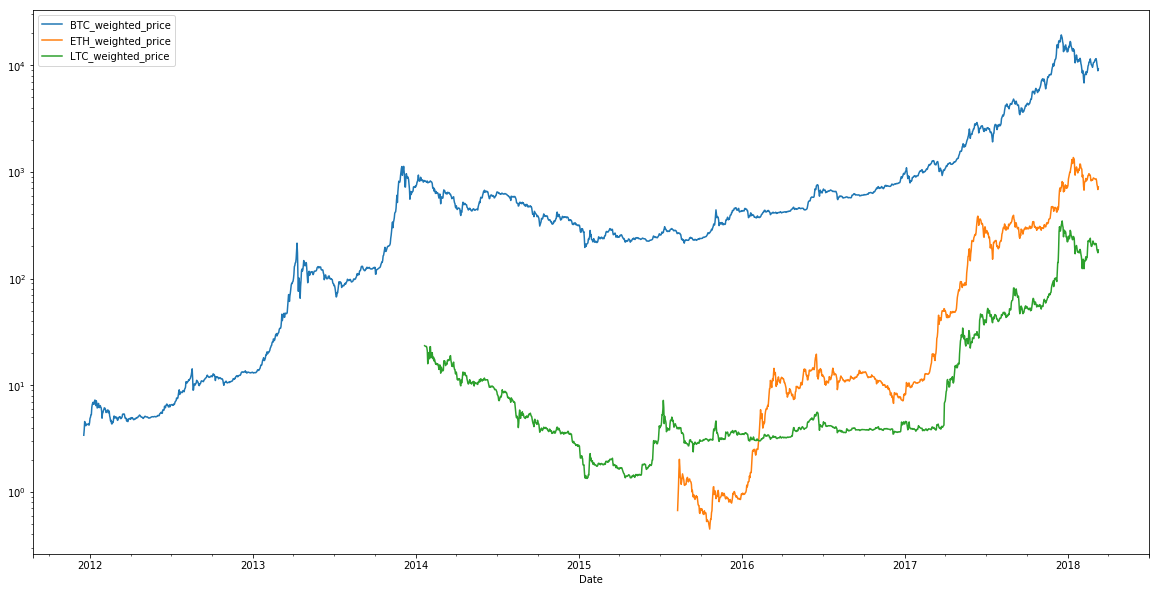

In [14]:
plt.rcParams['figure.figsize'] = (20,10)
coins.filter(regex="weighted_price").plot(logy=True)

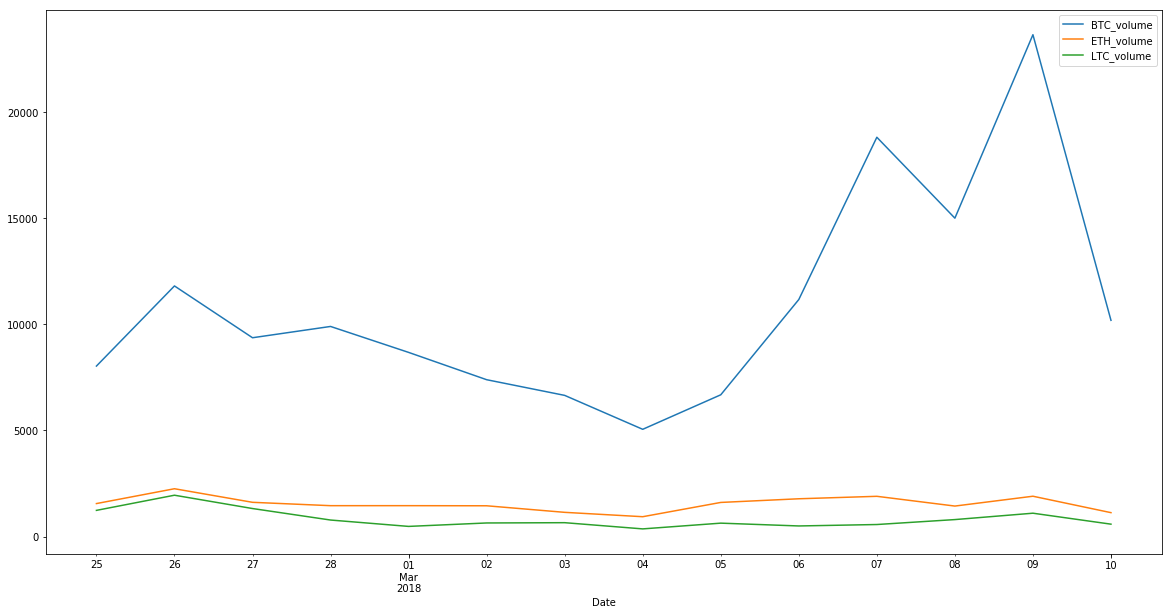

In [15]:
coins.filter(regex="volume").tail(14).plot()

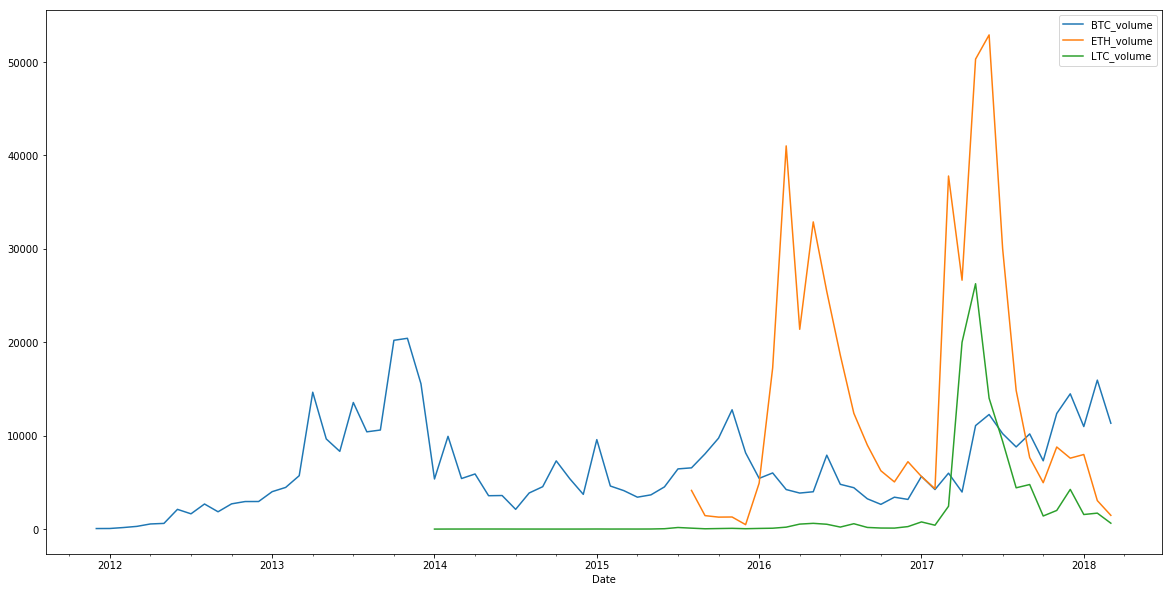

In [16]:
coins.resample('M').mean().filter(regex="volume").plot()

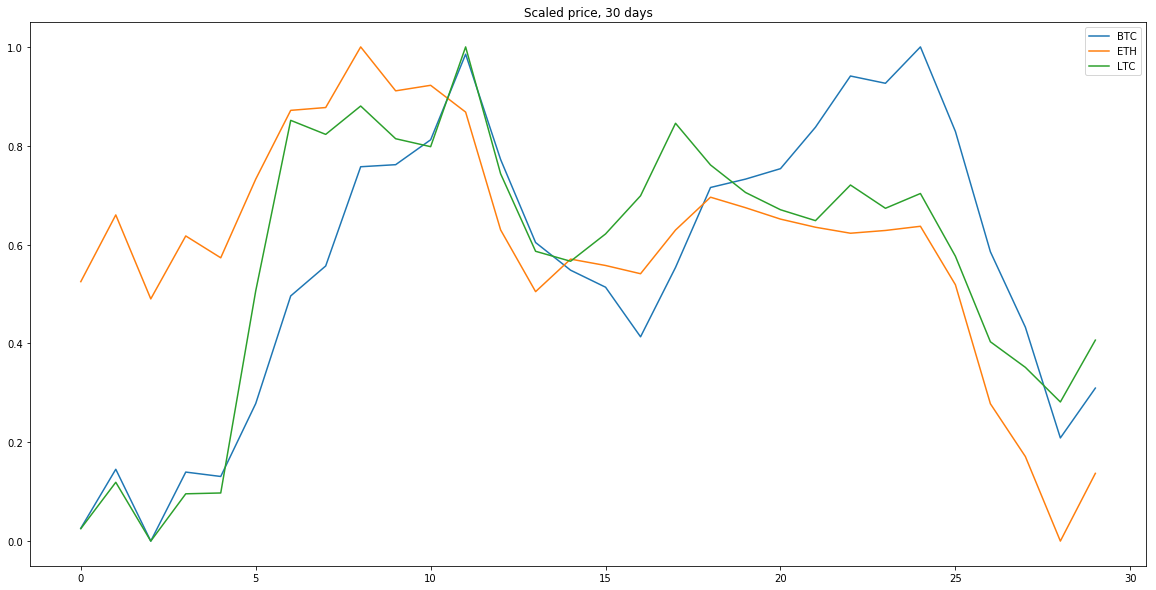

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
volume_scaled = pd.DataFrame(scaler.fit_transform(coins.filter(regex="weighted_price").tail(30).dropna()), columns=["BTC", "ETH", "LTC"])
volume_scaled.plot(title="Scaled price, 30 days")

In [18]:
corrcoins = coins.filter(regex="weighted_price")
corrcoins.columns = ["BTC", "ETH", "LTC"]

corr = corrcoins.pct_change().corr(method="pearson")

combined_df_2016 = corrcoins[corrcoins.index.year == 2016]
corr2016 = combined_df_2016.pct_change().corr(method='pearson')

combined_df_2017 = corrcoins[corrcoins.index.year == 2017]
corr2017 = combined_df_2017.pct_change().corr(method='pearson')

combined_df_2018 = corrcoins[corrcoins.index.year == 2018]
corr2018 = combined_df_2018.pct_change().corr(method='pearson')

begin = str(date.today() - timedelta(days=14))
today = str(date.today())

combined_df_14D = corrcoins[begin:today]
corr14D = combined_df_14D.pct_change().corr(method='pearson')
corr14D

,BTC,ETH,LTC
BTC,1.000000,0.918826,0.720608
ETH,0.918826,1.000000,0.803000
LTC,0.720608,0.803000,1.000000


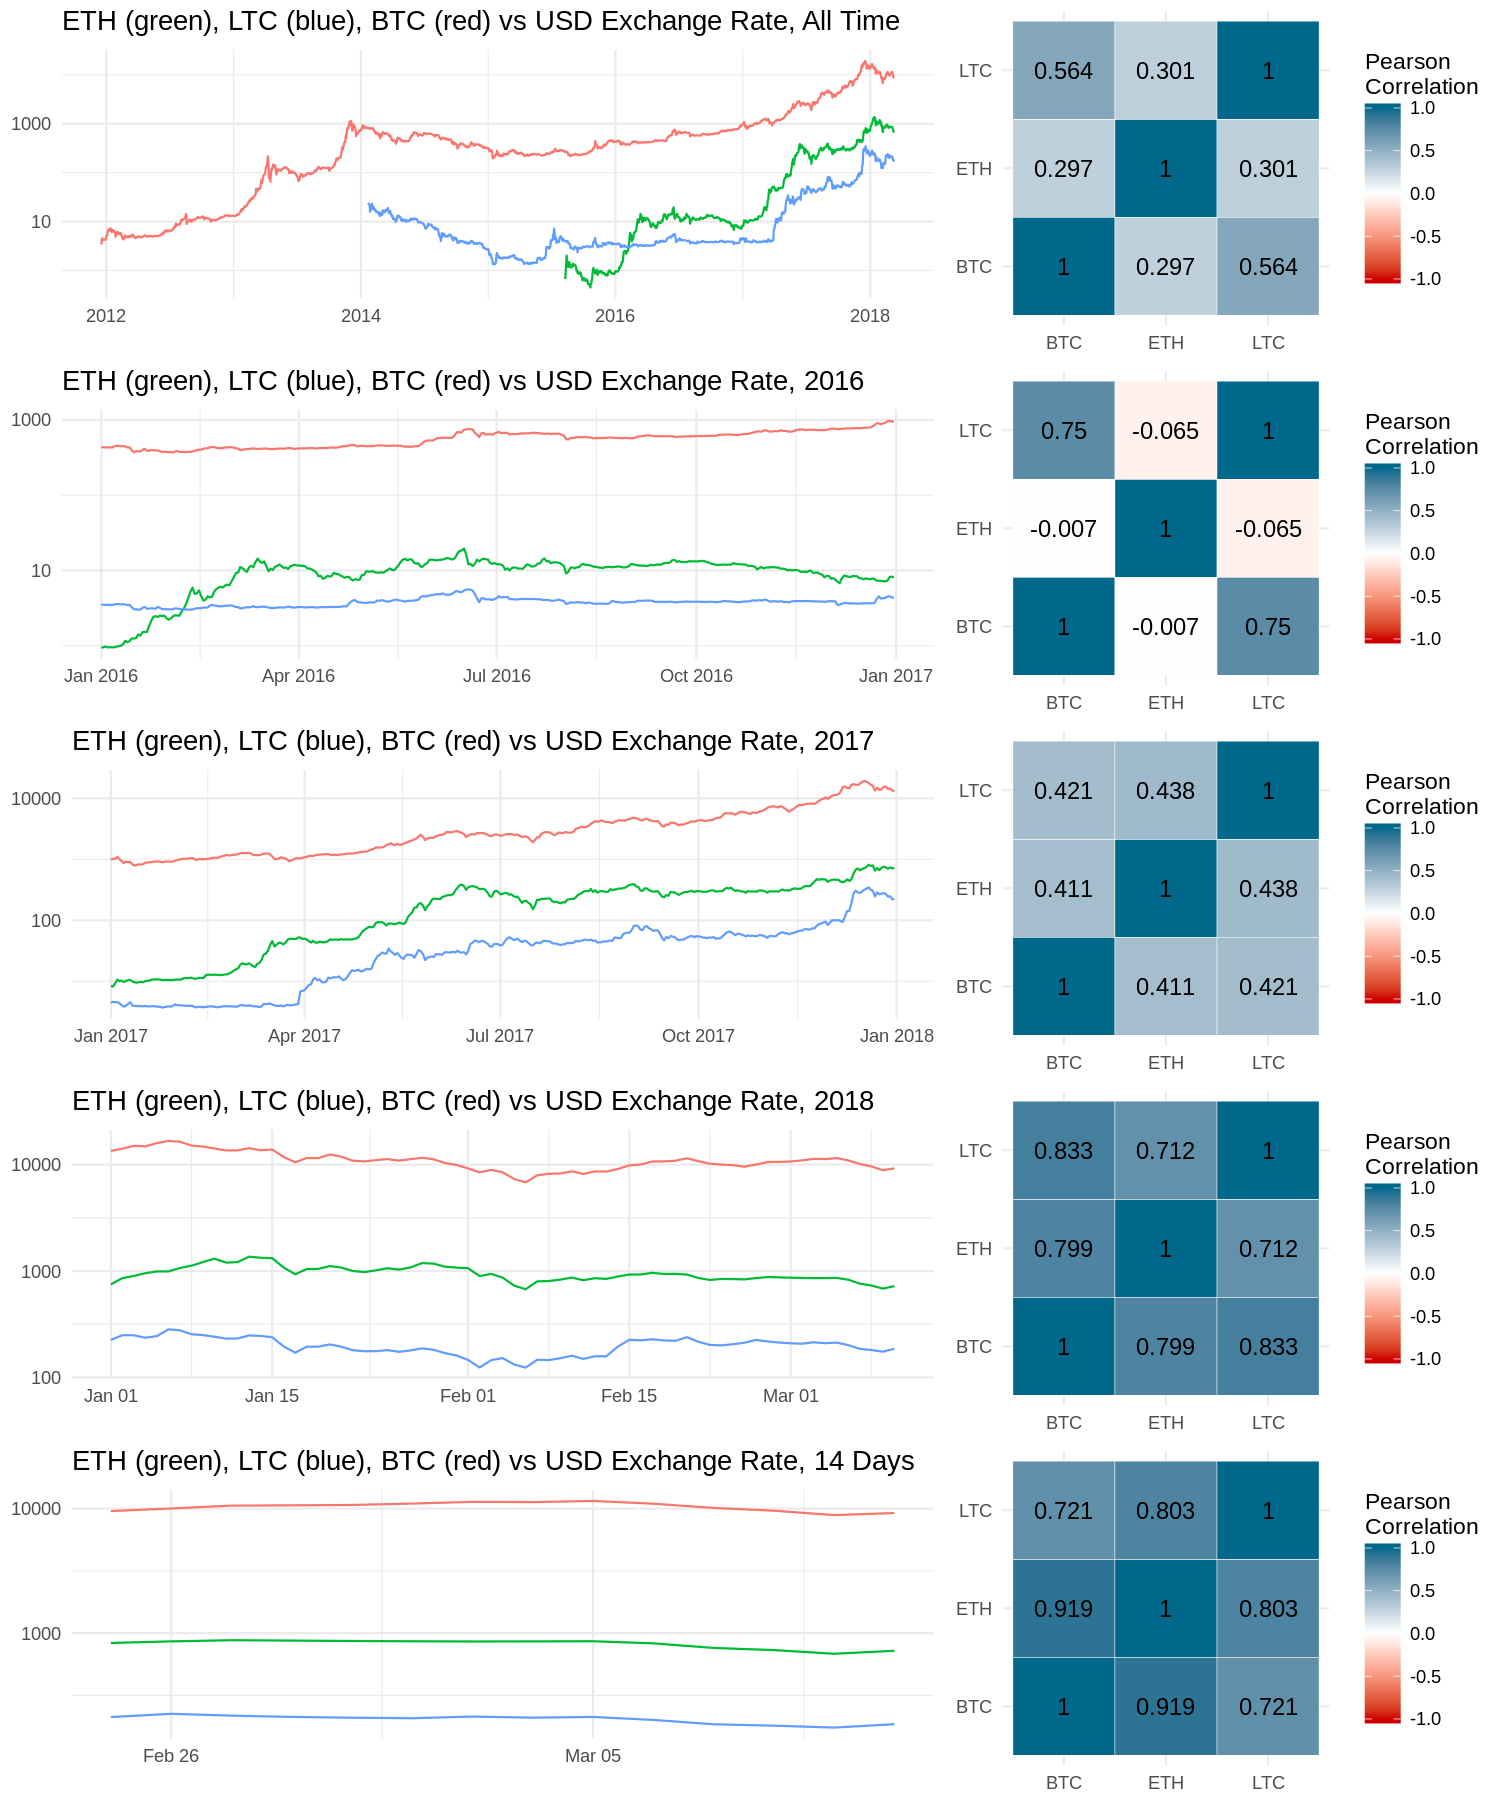

In [19]:
%%R -i coins -i corr -i corr2016 -i corr2017 -i corr2018 -i corr14D -w 10 -h 12 --units in -r 150

series <- coins %>%
    select(BTC_weighted_price, ETH_weighted_price, LTC_weighted_price) %>%
    rownames_to_column('Date') %>%
    mutate_at(1, as.Date) %>%
    melt(id='Date') %>%
    ggplot(aes(x=Date, y=value, color=variable)) +
        geom_line() +
        scale_y_continuous(trans='log10') +
        labs(title='ETH (green), LTC (blue), BTC (red) vs USD Exchange Rate, All Time', x='', y=NULL) +
        theme_minimal() +
        theme(legend.position='none')

corr <- corr %>%
    as.matrix() %>%
    round(3) %>%
    melt() %>%
    ggplot(aes(x = Var1, y = Var2, fill = value)) + 
        theme_minimal() +
        labs(title=NULL, x=NULL, y=NULL) +
        geom_tile(color = 'white') +
        scale_fill_gradient2(high = 'deepskyblue4', low = 'red3', mid = 'white', midpoint = 0, limit = c(-1,1), space = 'Lab', name='Pearson\nCorrelation') +
        geom_text(aes(Var2, Var1, label = value), color = 'black', size = 4)
    
series2016 <- coins %>%
    select(BTC_weighted_price, ETH_weighted_price, LTC_weighted_price) %>%
    rownames_to_column('Date') %>%
    mutate_at(1, as.Date) %>%
    filter(Date >= '2016-01-01', Date < '2017-01-01') %>%
    melt(id='Date') %>%
    ggplot(aes(x=Date, y=value, color=variable)) +
        geom_line() +
        scale_y_continuous(trans='log10') +
        labs(title='ETH (green), LTC (blue), BTC (red) vs USD Exchange Rate, 2016', x='', y=NULL) +
        theme_minimal() +
        theme(legend.position='none')
    
corr2016 <- corr2016 %>%
    as.matrix() %>%
    round(3) %>%
    melt() %>%
    ggplot(aes(x = Var1, y = Var2, fill = value)) + 
        theme_minimal() +
        labs(title=NULL, x=NULL, y=NULL) +
        geom_tile(color = 'white') +
        scale_fill_gradient2(high = 'deepskyblue4', low = 'red3', mid = 'white', midpoint = 0, limit = c(-1,1), space = 'Lab', name='Pearson\nCorrelation') +
        geom_text(aes(Var2, Var1, label = value), color = 'black', size = 4)
    
series2017 <- coins %>%
    select(BTC_weighted_price, ETH_weighted_price, LTC_weighted_price) %>%
    rownames_to_column('Date') %>%
    mutate_at(1, as.Date) %>%
    filter(Date >= '2017-01-01', Date < '2018-01-01') %>%
    melt(id='Date') %>%
    ggplot(aes(x=Date, y=value, color=variable)) +
        geom_line() +
        scale_y_continuous(trans='log10') +
        labs(title='ETH (green), LTC (blue), BTC (red) vs USD Exchange Rate, 2017', x='', y=NULL) +
        theme_minimal() +
        theme(legend.position='none')
    
corr2017 <- corr2017 %>%
    as.matrix() %>%
    round(3) %>%
    melt() %>%
    ggplot(aes(x = Var1, y = Var2, fill = value)) + 
        theme_minimal() +
        labs(title=NULL, x=NULL, y=NULL) +
        geom_tile(color = "white") +
        scale_fill_gradient2(high = "deepskyblue4", low = "red3", mid = "white", midpoint = 0, limit = c(-1,1), space = "Lab", name="Pearson\nCorrelation") +
        geom_text(aes(Var2, Var1, label = value), color = 'black', size = 4)
    
series2018 <- coins %>%
    select(BTC_weighted_price, ETH_weighted_price, LTC_weighted_price) %>%
    rownames_to_column('Date') %>%
    mutate_at(1, as.Date) %>%
    filter(Date >= '2018-01-01') %>%
    melt(id='Date') %>%
    ggplot(aes(x=Date, y=value, color=variable)) +
        geom_line() +
        scale_y_continuous(trans='log10') +
        labs(title='ETH (green), LTC (blue), BTC (red) vs USD Exchange Rate, 2018', x='', y=NULL) +
        theme_minimal() +
        theme(legend.position='none')
    
corr2018 <- corr2018 %>%
    as.matrix() %>%
    round(3) %>%
    melt() %>%
    ggplot(aes(x = Var1, y = Var2, fill = value)) + 
        theme_minimal() +
        labs(title=NULL, x=NULL, y=NULL) +
        geom_tile(color = "white") +
        scale_fill_gradient2(high = "deepskyblue4", low = "red3", mid = "white", midpoint = 0, limit = c(-1,1), space = "Lab", name="Pearson\nCorrelation") +
        geom_text(aes(Var2, Var1, label = value), color = 'black', size = 4)
        
series14D <- coins %>%
    select(BTC_weighted_price, ETH_weighted_price, LTC_weighted_price) %>%
    rownames_to_column('Date') %>%
    mutate_at(1, as.Date) %>%
    filter(Date >= Sys.Date() - 14) %>%
    melt(id='Date') %>%
    ggplot(aes(x=Date, y=value, color=variable)) +
        geom_line() +
        scale_y_continuous(trans='log10') +
        labs(title='ETH (green), LTC (blue), BTC (red) vs USD Exchange Rate, 14 Days', x='', y=NULL) +
        theme_minimal() +
        theme(legend.position='none')
    
corr14D <- corr14D %>%
    as.matrix() %>%
    round(3) %>%
    melt() %>%
    ggplot(aes(x = Var1, y = Var2, fill = value)) + 
        theme_minimal() +
        labs(title=NULL, x=NULL, y=NULL) +
        geom_tile(color = "white") +
        scale_fill_gradient2(high = "deepskyblue4", low = "red3", mid = "white", midpoint = 0, limit = c(-1,1), space = "Lab", name="Pearson\nCorrelation") +
        geom_text(aes(Var2, Var1, label = value), color = 'black', size = 4)        
        
        plot_grid(series, corr, series2016, corr2016, series2017, corr2017, series2018, corr2018, series14D, corr14D, labels=NULL, nrow=5, ncol=2, rel_widths=c(0.63, 0.37))

In [20]:
graph.delete_all()

In [21]:
batch = Transaction(graph)

batch.run("""
    CREATE (master:Calendar {name: 'master'})
        WITH range(2011, 2018) AS years, range(1, 12) AS months, master
        FOREACH (year IN years |
            CREATE (y:Year {year: year})
            MERGE (master)-[:YEAR]->(y)
            FOREACH (month IN months |
                CREATE (m:Month {year: year, month: month})
                MERGE (y)-[:MONTH]->(m)
                FOREACH (day IN (CASE
                    WHEN month IN [1, 3, 5, 7, 8, 10, 12] THEN range(1, 31)
                    WHEN month = 2 THEN
                        CASE
                            WHEN year % 4 <> 0 THEN range(1, 28)
                            WHEN year % 100 <> 0 THEN range(1, 29)
                            WHEN year % 400 <> 0 THEN range(1, 29)
                            ELSE range(1, 28)
                        END
                    ELSE range(1, 30) 
                END ) | 
            CREATE (d:Day {year: year, month: month, day: day})
            MERGE (m)-[:DAY]->(d))))
    WITH *
    MATCH (year:Year)-[:MONTH]->(month)-[:DAY]->(day)
    WITH year, month, day
    ORDER BY year.year, month.month, day.day
    WITH collect(day) as days
    FOREACH(i in RANGE(0, length(days)-2) |
        FOREACH(day1 in [days[i]] |
            FOREACH(day2 in [days[i+1]] |
                CREATE UNIQUE (day1)-[:NEXT]->(day2))))
    WITH *
    MATCH (year:Year)-[:MONTH]->(month)
    WITH year, month
    ORDER BY year.year, month.month
    WITH collect(month) as months
    FOREACH(i in RANGE(0, length(months)-2) |
        FOREACH(month1 in [months[i]] |
            FOREACH(month2 in [months[i+1]] |
                CREATE UNIQUE (month1)-[:NEXT]->(month2))))
    WITH *
    MATCH (year:Year)
    WITH year
    ORDER BY year.year
    WITH collect(year) as years
    FOREACH(i in RANGE(0, length(years)-2) |
        FOREACH(year1 in [years[i]] |
            FOREACH(year2 in [years[i+1]] |
                CREATE UNIQUE (year1)-[:NEXT]->(year2))))
    """)

[batch.run("""
    CREATE (n: Coin {coin: $coin})
    """, parameters = {"coin": coin})
    for coin in ["BTC", "ETH", "LTC"]]
   
    
[[batch.run("""
    MATCH (c:Coin), (d:Day)
    WHERE c.coin=$coin AND d.day=$day AND d.month=$month AND d.year=$year
    CREATE (c)-[:RECORD{date: $date,
                        weightedPrice: $weightedPrice,
                        volume: $volume,
                        pcntChange: $pcntChange,
                        open: $open,
                        high: $high,
                        low: $low,
                        close: $close}]->(d)
    """, parameters = {"coin": coin,
                       "year": int(index.strftime("%Y")),
                       "month": int(index.strftime("%m")),
                       "day": int(index.strftime("%d")),
                       "date": index.strftime("%Y-%m-%d"),
                       "weightedPrice": coins.loc[index, "{}_weighted_price".format(coin)],
                       "volume": coins.loc[index, "{}_volume".format(coin)],
                       "pcntChange": coins.loc[index, "{}_pcnt_change".format(coin)],
                       "open": coins.loc[index, "{}_open".format(coin)],
                       "high": coins.loc[index, "{}_high".format(coin)],
                       "low": coins.loc[index, "{}_low".format(coin)],
                       "close": coins.loc[index, "{}_close".format(coin)]})
    for index in coins.filter(regex=(coin)).dropna().index] for coin in ["BTC", "ETH", "LTC"]]

batch.commit()

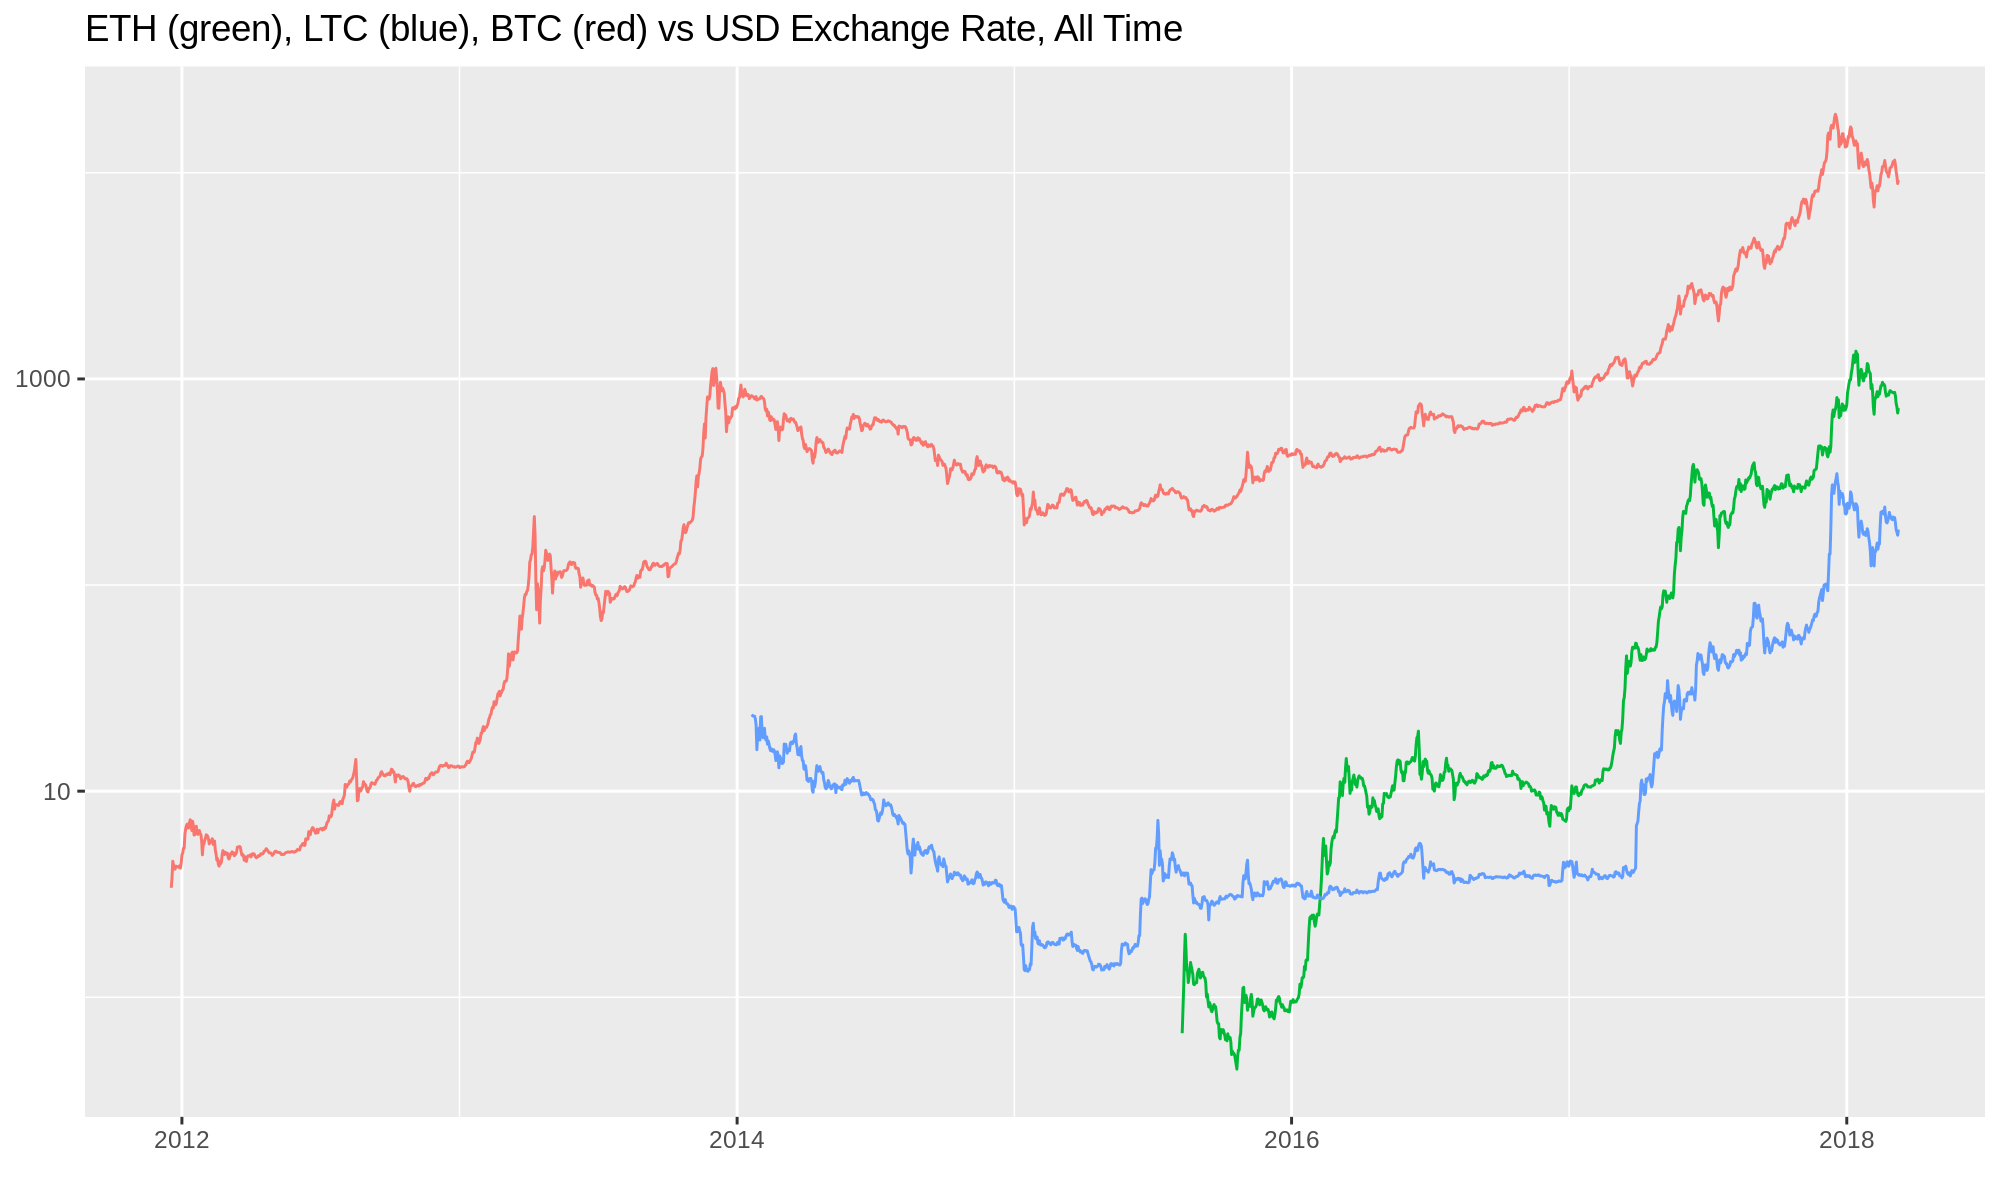

In [23]:
%%R -i coins -w 10 -h 6 --units in -r 200

series <- coins %>%
    select(BTC_weighted_price, ETH_weighted_price, LTC_weighted_price) %>%
    rownames_to_column('Date') %>%
    mutate_at(1, as.Date) %>%
    melt(id='Date') %>%
    ggplot(aes(x=Date, y=value, color=variable)) +
        geom_line() +
        scale_y_continuous(trans='log10') +
        labs(title='ETH (green), LTC (blue), BTC (red) vs USD Exchange Rate, All Time', x='', y=NULL) +
        theme(legend.position='none')
        
series